### Importing Libraries:

In [ ]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import tensorflow.keras as keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import tensorflow.keras as keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
!pip install seaborn

## Question 1:
### Data Exploration & Preparation:

Training data size: 60000 images
Testing data size: 10000 images
Image dimensions (Training): 28x28
Image dimensions (Testing): 28x28
Number of unique classes: 10


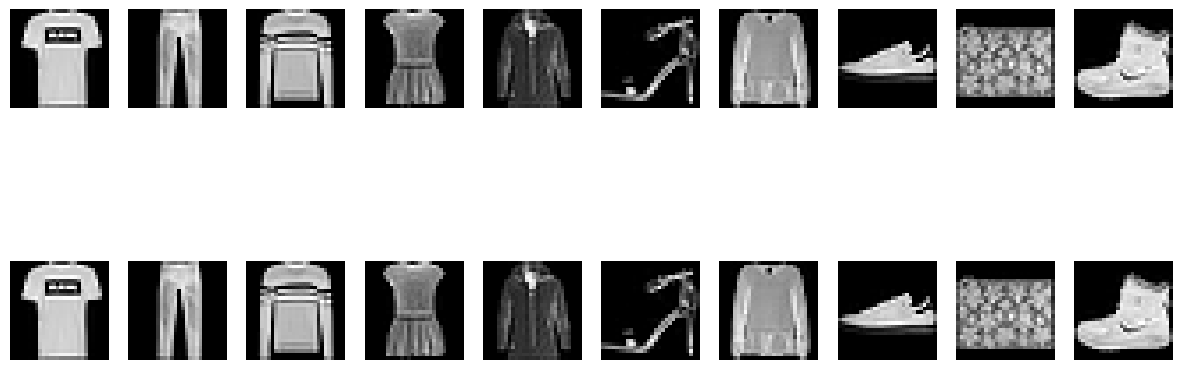

In [1]:

# Load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Verify the size of the datasets
print(f"Training data size: {x_train.shape[0]} images")
print(f"Testing data size: {x_test.shape[0]} images")

# Verify the dimensions of each image
print(f"Image dimensions (Training): {x_train.shape[1]}x{x_train.shape[2]}")
print(f"Image dimensions (Testing): {x_test.shape[1]}x{x_test.shape[2]}")

# Verify the number of classes
print(f"Number of unique classes: {len(np.unique(y_train))}")

# Normalize the images to [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshaping for CNNs (adding channel dimension)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# One-hot encoding labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Visualizing sample images (20 images in this case)
fig, ax = plt.subplots(2, 10, figsize=(15, 6))  # 2 rows, 10 columns
for i in range(20):
    ax[i // 10, i % 10].imshow(x_train[y_train.argmax(axis=1) == i % 10][0], cmap='gray')
    ax[i // 10, i % 10].axis('off')
plt.show()


### Model Development:

In [2]:


# Model 1: Shallow Neural Network
model1 = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model 2: Basic CNN
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model 3: Deeper CNN
model3 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print summaries of models
model1.summary()
model2.summary()
model3.summary()


/Users/asmae/Documents/GitHub/assignment3_ML/myenv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/asmae/Documents/GitHub/assignment3_ML/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       692,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,962 (2.65 MB)

 Trainable params: 693,962 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,522 (3.42 MB)

 Trainable params: 896,522 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

### Training & Validation:

#### Training Model 1:

In [ ]:
history1 = model1.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test))
model1.save_weights('model1_best_weights.weights.h5')

#### Training Model 2:

In [ ]:
history2 = model2.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test))
model2.save_weights('model2_best_weights.weights.h5')

#### Training Model 3:

In [ ]:
history3 = model3.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test))
model3.save_weights('model3_best_weights.weights.h5')

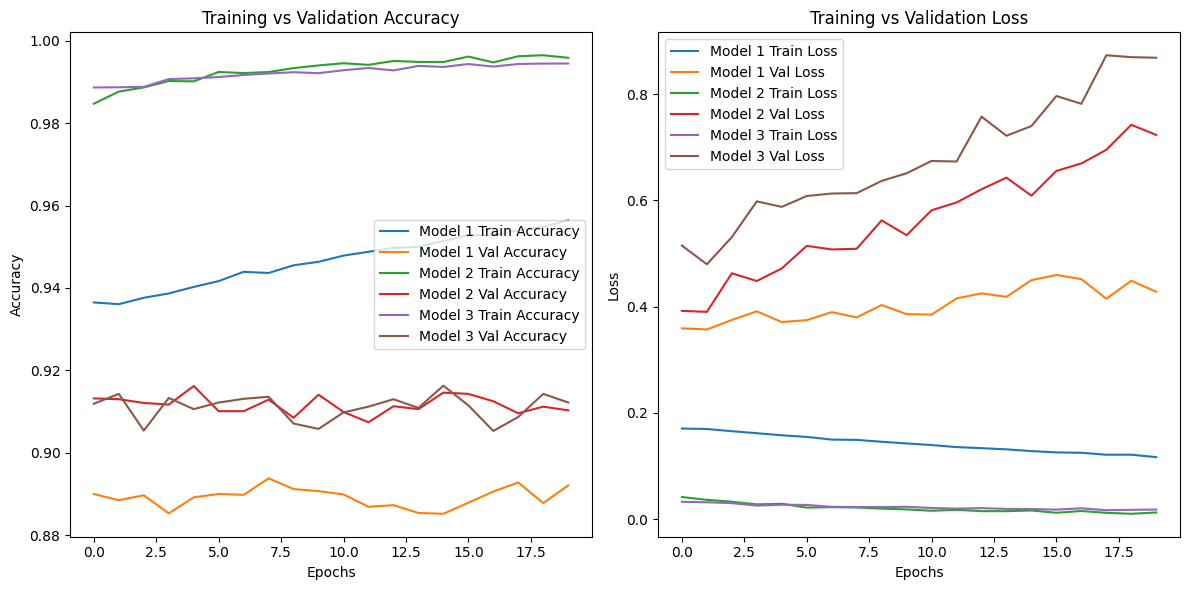

In [16]:

# Plotting training & validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Model 1 Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Model 1 Val Accuracy')
plt.plot(history2.history['accuracy'], label='Model 2 Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Model 2 Val Accuracy')
plt.plot(history3.history['accuracy'], label='Model 3 Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Model 3 Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Model 1 Train Loss')
plt.plot(history1.history['val_loss'], label='Model 1 Val Loss')
plt.plot(history2.history['loss'], label='Model 2 Train Loss')
plt.plot(history2.history['val_loss'], label='Model 2 Val Loss')
plt.plot(history3.history['loss'], label='Model 3 Train Loss')
plt.plot(history3.history['val_loss'], label='Model 3 Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Model Evaluation

#### Assess each model's performance on the test data, reporting accuracy.

In [ ]:
test_loss, test_acc = model1.evaluate(x_test, y_test)
print(f"Test accuracy of Model 1: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - accuracy: 0.8773 - loss: 0.3380
Test accuracy of Model 1: 0.879800021648407


In [ ]:
test_loss, test_acc = model2.evaluate(x_test, y_test)
print(f"Test accuracy of Model 2: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9114 - loss: 0.3339
Test accuracy of Model 2: 0.9160000085830688


In [ ]:
test_loss, test_acc = model3.evaluate(x_test, y_test)
print(f"Test accuracy of Model 3: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9091 - loss: 0.3705
Test accuracy of Model 3: 0.9085999727249146


### 1. Construct a committee by averaging predictions of the three models.
### 2. Report on the combined accuracy of the committee.

In [17]:
# Get predictions for each model
predictions1 = model1.predict(x_test)
predictions2 = model2.predict(x_test)
predictions3 = model3.predict(x_test)

# Combine predictions (committee) by averaging the predicted probabilities
final_predictions = (predictions1 + predictions2 + predictions3) / 3

# Get the class with the highest probability for each prediction
final_predictions = final_predictions.argmax(axis=1)

# Compute accuracy for the committee
committee_accuracy = np.mean(final_predictions == y_test.argmax(axis=1))
print(f"Committee accuracy: {committee_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Committee accuracy: 0.9274


### Performance Metrics & Analysis:

In [ ]:
# Get predictions for each model
predictions1 = model1.predict(x_test)
predictions2 = model2.predict(x_test)
predictions3 = model3.predict(x_test)

# Combine predictions for the committee (averaging the predictions)
final_predictions = (predictions1 + predictions2 + predictions3) / 3
final_predictions = final_predictions.argmax(axis=1)  # Get the class with the highest score

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


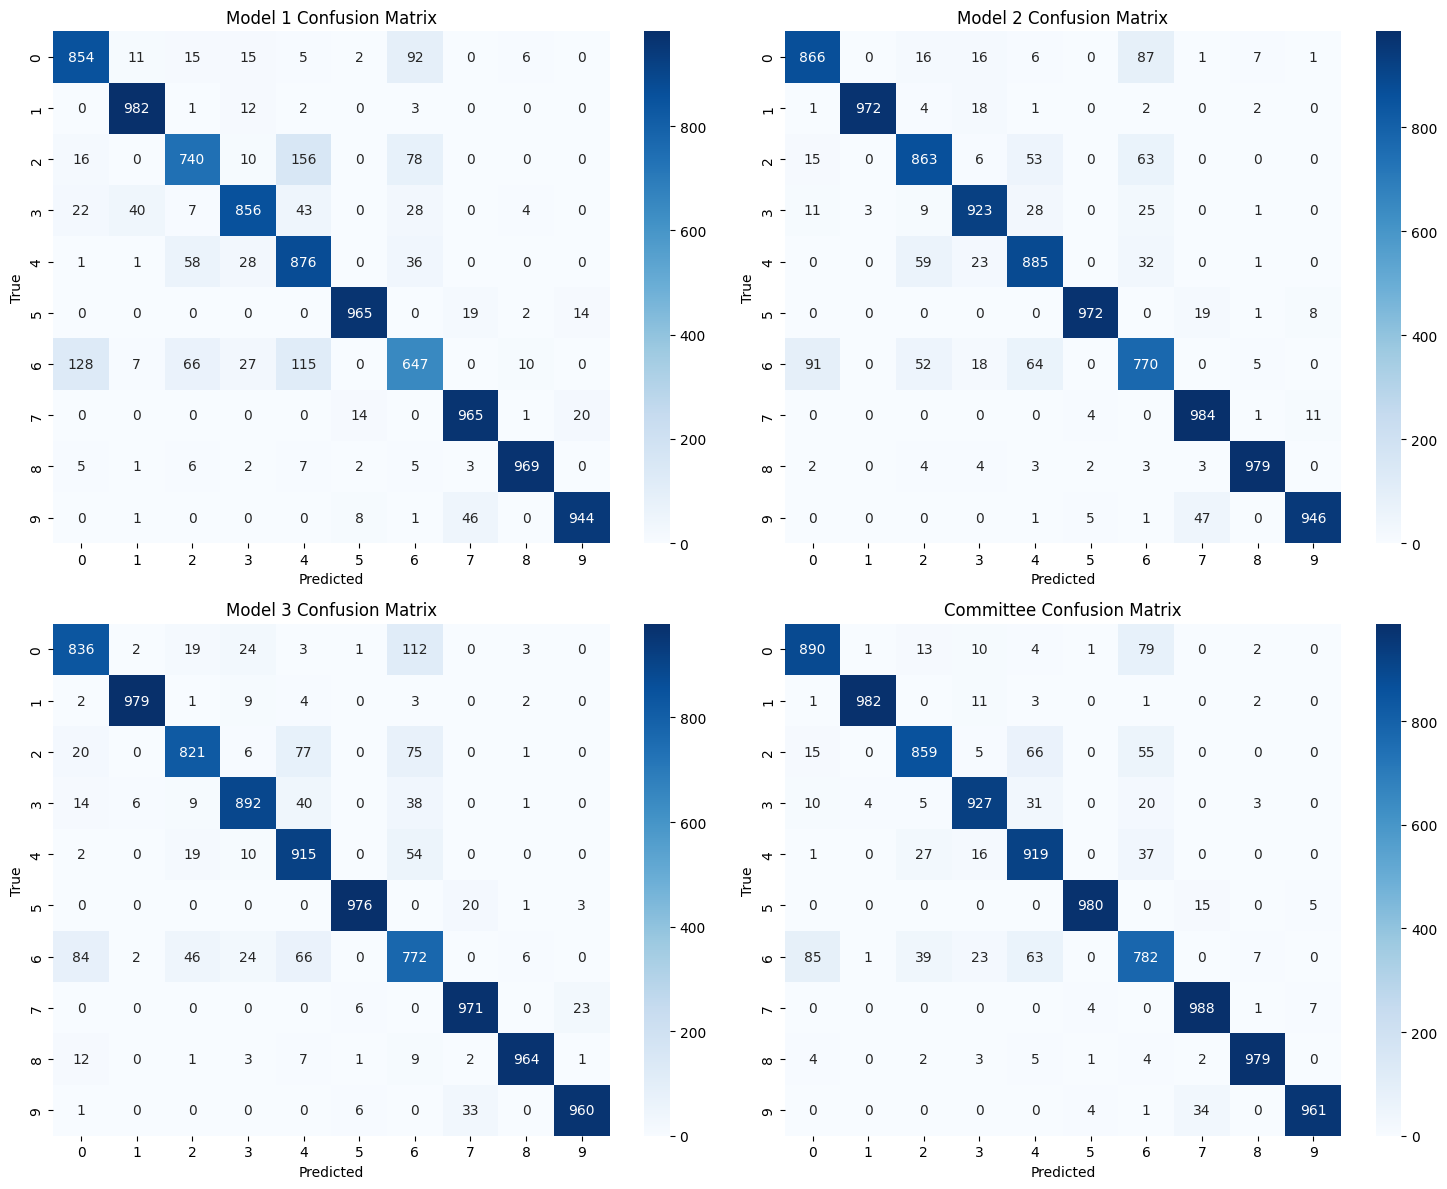

Model 1 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1000
           1       0.94      0.98      0.96      1000
           2       0.83      0.74      0.78      1000
           3       0.90      0.86      0.88      1000
           4       0.73      0.88      0.79      1000
           5       0.97      0.96      0.97      1000
           6       0.73      0.65      0.68      1000
           7       0.93      0.96      0.95      1000
           8       0.98      0.97      0.97      1000
           9       0.97      0.94      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Model 2 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1000
           1       1.00      0.97      0.98      1000
           2    

In [ ]:
# Confusion matrix for models
cm1 = confusion_matrix(y_test.argmax(axis=1), predictions1.argmax(axis=1))
cm2 = confusion_matrix(y_test.argmax(axis=1), predictions2.argmax(axis=1))
cm3 = confusion_matrix(y_test.argmax(axis=1), predictions3.argmax(axis=1))

# Confusion matrix for the committee
cm_final = confusion_matrix(y_test.argmax(axis=1), final_predictions)

# Plot confusion matrix heatmaps
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

# Model 1 Confusion Matrix
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=ax[0, 0])
ax[0, 0].set_title("Model 1 Confusion Matrix")
ax[0, 0].set_xlabel('Predicted')
ax[0, 0].set_ylabel('True')

# Model 2 Confusion Matrix
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=ax[0, 1])
ax[0, 1].set_title("Model 2 Confusion Matrix")
ax[0, 1].set_xlabel('Predicted')
ax[0, 1].set_ylabel('True')

# Model 3 Confusion Matrix
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', ax=ax[1, 0])
ax[1, 0].set_title("Model 3 Confusion Matrix")
ax[1, 0].set_xlabel('Predicted')
ax[1, 0].set_ylabel('True')

# Committee Confusion Matrix
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', ax=ax[1, 1])
ax[1, 1].set_title("Committee Confusion Matrix")
ax[1, 1].set_xlabel('Predicted')
ax[1, 1].set_ylabel('True')

plt.tight_layout()
plt.show()

# Classification reports
cr1 = classification_report(y_test.argmax(axis=1), predictions1.argmax(axis=1))
cr2 = classification_report(y_test.argmax(axis=1), predictions2.argmax(axis=1))
cr3 = classification_report(y_test.argmax(axis=1), predictions3.argmax(axis=1))
cr_final = classification_report(y_test.argmax(axis=1), final_predictions)

# Print classification reports
print("Model 1 Classification Report:")
print(cr1)

print("Model 2 Classification Report:")
print(cr2)

print("Model 3 Classification Report:")
print(cr3)

print("Committee Classification Report:")
print(cr_final)


### Classification Report 

In [20]:
# Classification reports for each model and committee
cr1 = classification_report(y_test.argmax(axis=1), model1.predict(x_test).argmax(axis=1), output_dict=True)
cr2 = classification_report(y_test.argmax(axis=1), model2.predict(x_test).argmax(axis=1), output_dict=True)
cr3 = classification_report(y_test.argmax(axis=1), model3.predict(x_test).argmax(axis=1), output_dict=True)
cr_committee = classification_report(y_test.argmax(axis=1), final_predictions, output_dict=True)

# Convert the reports to DataFrame for easy visualization
df1 = pd.DataFrame(cr1).transpose()
df2 = pd.DataFrame(cr2).transpose()
df3 = pd.DataFrame(cr3).transpose()
df_committee = pd.DataFrame(cr_committee).transpose()

# Displaying the DataFrames in a readable format
print("Model 1 Classification Report")
print(df1)

print("Model 2 Classification Report")
print(df2)

print("Model 3 Classification Report")
print(df3)

print("Committee Classification Report")
print(df_committee)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model 1 Classification Report
              precision  recall  f1-score     support
0              0.815370  0.8700  0.841800   1000.0000
1              0.993915  0.9800  0.986908   1000.0000
2              0.810783  0.7970  0.803833   1000.0000
3              0.892368  0.9120  0.902077   1000.0000
4              0.820359  0.8220  0.821179   1000.0000
5              0.980473  0.9540  0.967055   1000.0000
6              0.731838  0.6850  0.707645   1000.0000
7              0.938716  0.9650  0.951677   1000.0000
8              0.976000  0.9760  0.976000   1000.0000
9              0.957129  0.9600  0.958562   1000.0000
accuracy       0.892100  0.8921  0.892100      0.8921
macro avg      0.891695  0.8921  0.891674  10000.0000
weighted avg   0.891695  0.8921  0.891674  10000.0000
Model 2 Classification Report
              precision  recall  f1-score     support
0  

## Extra Task

### Model Setup with Batch Normalization and Dropout

In [ ]:
# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize the images to [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshaping for CNNs (adding channel dimension)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# One-hot encoding labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# Define the model with Batch Normalization and Dropout
model = keras.Sequential([
    layers.InputLayer(input_shape=x_train.shape[1:]),  # Input shape (28, 28, 1)
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    
    layers.Dense(10, activation='softmax')  # Output layer with 10 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()



/Users/asmae/Documents/GitHub/assignment3_ML/myenv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,026 (1.61 MB)

 Trainable params: 421,834 (1.61 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.6513 - loss: 1.0106 - val_accuracy: 0.8099 - val_loss: 0.5063
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.7773 - loss: 0.5888 - val_accuracy: 0.8352 - val_loss: 0.4621
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.8029 - loss: 0.5264 - val_accuracy: 0.8398 - val_loss: 0.4387
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.8255 - loss: 0.4785 - val_accuracy: 0.8637 - val_loss: 0.3819
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.8302 - loss: 0.4571 - val_accuracy: 0.8651 - val_loss: 0.3717
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.8404 - loss: 0.4319 - val_accuracy: 0.8781 - val_loss: 0.3399
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.8444 - loss: 0.4172 - val_accuracy: 0.8596 - val_loss: 0.3769
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8472 - loss: 0.4126 - 

ValueError: The filename must end in `.weights.h5`. Received: filepath=fashion_mnist_model_best_weights.h5

### Train the model:

In [ ]:
# Train the model with data augmentation
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    epochs=20,
                    validation_data=(x_test, y_test))

# Save the best model weights
model.save_weights('fashion_mnist_model_best_weights.h5')

### Advanced ensembling:  (Weighted Averaging)

In [ ]:
# Predictions from the models (example)
predictions1 = model1.predict(x_test)
predictions2 = model2.predict(x_test)
predictions3 = model3.predict(x_test)

# Combine predictions (committee) by weighted averaging based on validation performance
weights = [0.5, 0.25, 0.25]  # Example weights, adjust based on validation performance
final_predictions = (weights[0] * predictions1 + weights[1] * predictions2 + weights[2] * predictions3)

# Get the class with the highest probability for each prediction
final_predictions = final_predictions.argmax(axis=1)

# Compute accuracy for the committee
committee_accuracy = np.mean(final_predictions == y_test.argmax(axis=1))
print(f"Committee accuracy: {committee_accuracy}")

### Visual Aids: Confusion Matrix Heatmaps

In [ ]:
# Confusion Matrix for the committee
cm = confusion_matrix(y_test.argmax(axis=1), final_predictions)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Committee Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Training Curves (Accuracy and Loss)

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Model Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Model Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Model Train Loss')
plt.plot(history.history['val_loss'], label='Model Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Classification Reports

In [ ]:
# Classification reports for the committee and individual models
cr_committee = classification_report(y_test.argmax(axis=1), final_predictions)
print("Committee Classification Report")
print(cr_committee)

# You can also print classification reports for individual models like model1, model2, and model3
cr1 = classification_report(y_test.argmax(axis=1), model1.predict(x_test).argmax(axis=1))
cr2 = classification_report(y_test.argmax(axis=1), model2.predict(x_test).argmax(axis=1))
cr3 = classification_report(y_test.argmax(axis=1), model3.predict(x_test).argmax(axis=1))

print("Model 1 Classification Report")
print(cr1)
print("Model 2 Classification Report")
print(cr2)
print("Model 3 Classification Report")
print(cr3)

## Question 2: Network with Batch Normalization and Dropout Layers

![Neural Network Architecture](./architecture.png)

In [ ]:
# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize the images to [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshaping for CNNs (adding channel dimension)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# One-hot encoding labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

#### Data Augmentation: I have applied transformations; rotation, width/height shift, zoom, and flip to increase the variety of training data

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

In [ ]:
# Define the model with Batch Normalization and Dropout
input = keras.layers.Input(shape=x_train.shape[1:])  # Input layer (28, 28, 1)
hidden1 = layers.Dense(30, activation='relu')(input)  # First hidden layer
hidden1_bn = layers.BatchNormalization()(hidden1)  # Batch Normalization after first hidden layer
hidden1_drop = layers.Dropout(0.3)(hidden1_bn)  # Dropout after Batch Normalization

hidden2 = layers.Dense(30, activation='relu')(hidden1_drop)  # Second hidden layer
hidden2_bn = layers.BatchNormalization()(hidden2)  # Batch Normalization after second hidden layer
hidden2_drop = layers.Dropout(0.3)(hidden2_bn)  # Dropout after Batch Normalization

concat = layers.concatenate([input, hidden2_drop])  # Concatenate input and hidden2 layers

output = layers.Dense(10, activation='softmax')(concat)  # Output layer with softmax activation

model = keras.models.Model(inputs=[input], outputs=[output])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

In [ ]:
# Train the model with data augmentation
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    epochs=20,
                    validation_data=(x_test, y_test))

In [ ]:
# Save the best model weights
model.save_weights('fashion_mnist_model_best_weights.h5')

# Model Evaluation
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

In [ ]:
# Confusion Matrix
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
cr = classification_report(true_classes, predicted_classes)
print("Classification Report")
print(cr)

In [ ]:
# Plotting training & validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()